In [2]:
import torch
import math
import torchvision
import torchvision.transforms as transforms
from preresnet import PreResNet
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tqdm.notebook as tq

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(
    root='.data', train=True, download=True, transform=transform)

test_set = torchvision.datasets.CIFAR10(
    root='.data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes = ('plane', 'car', 'brid', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


In [5]:
model = PreResNet(32)

In [7]:
def forward(batch, model):
    images, labels = batch
    logits = model(images)
    _, predictions = logits.max(1)
    accuracy = (predictions == labels).sum() / batch[0].shape[0]
    loss = F.cross_entropy(logits, labels, reduction='mean')
    return loss, accuracy


def validation(test_loader, model):
    n = 0
    correct_count = 0.0
    total_loss = 0.0
    test_iter = iter(test_loader)
    with torch.no_grad():
        for batch in test_iter:
            batch_size = batch[0].shape[0]
            n += batch_size
            average_loss, accuracy = forward(batch, model)
            total_loss += average_loss * batch_size
            correct_count += accuracy * batch_size 
    return total_loss.item() / n, correct_count.item() / n


batch_size = 128
noise_scaling = 1
trainloader = torch.utils.data.DataLoader(
    train_set, batch_size=2 * batch_size, shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(
    test_set, batch_size=2 * batch_size, shuffle=False, num_workers=0)
losses = []
validation_losses = []
validation_accuracies = []
i = 0
learning_rate = 0.8
epochs = 300
c1 = (1 + math.sqrt(2 * noise_scaling - 1) / 2)
c2 = (1 - math.sqrt(2 * noise_scaling - 1) / 2)
for epoch in range(epochs):
    train_iter = iter(trainloader)
    if epoch == 249:
        learning_rate *= 0.1
    for images, labels in train_iter:
        n = images[0].shape[0] // 2
        batch1 = (images[:n], labels[:n])
        batch2 = (images[n:], labels[n:])
        loss1, _ = forward(
            batch1, model)
        loss2, _ = forward(batch2, model)
        loss = c1 * loss1 + c2 * loss2
        losses.append(loss.item())
        for p in model.parameters():
            p.grad = None
        loss.backward()
        for p in model.parameters():
            with torch.no_grad():
                p += - learning_rate / noise_scaling * p.grad
        if i % 100 == 0:
            validation_loss, validation_accuracy = validation(testloader, model)
            print(f'Loss: {validation_loss}, accuracy: {validation_accuracy}')
            validation_accuracies.append(validation_accuracy)
            validation_losses.append(validation_loss)
        i += 1
        print(f'{i} / {len(train_iter)}')


Loss: 7.09014140625, accuracy: 0.1
1 / 196
2 / 196
3 / 196
4 / 196
5 / 196
6 / 196
7 / 196
8 / 196
9 / 196
10 / 196
11 / 196
12 / 196
13 / 196
14 / 196
15 / 196
16 / 196
17 / 196
18 / 196
19 / 196
20 / 196
21 / 196
22 / 196
23 / 196
24 / 196
25 / 196
26 / 196
27 / 196
28 / 196
29 / 196
30 / 196
31 / 196
32 / 196
33 / 196
34 / 196
35 / 196
36 / 196
37 / 196
38 / 196
39 / 196
40 / 196
41 / 196
42 / 196
43 / 196
44 / 196
45 / 196
46 / 196
47 / 196
48 / 196
49 / 196
50 / 196
51 / 196
52 / 196
53 / 196
54 / 196
55 / 196
56 / 196
57 / 196
58 / 196
59 / 196
60 / 196
61 / 196
62 / 196
63 / 196
64 / 196
65 / 196
66 / 196
67 / 196
68 / 196
69 / 196
70 / 196
71 / 196
72 / 196
73 / 196
74 / 196
75 / 196
76 / 196
77 / 196
78 / 196
79 / 196
80 / 196
81 / 196
82 / 196
83 / 196
84 / 196
85 / 196
86 / 196
87 / 196
88 / 196
89 / 196
90 / 196
91 / 196
92 / 196
93 / 196
94 / 196
95 / 196
96 / 196
97 / 196
98 / 196
99 / 196
100 / 196
Loss: 2.5482986328125, accuracy: 0.1727
101 / 196
102 / 196
103 / 196
104

: 

: 

In [19]:
dataiter = iter(trainloader)
next(dataiter)

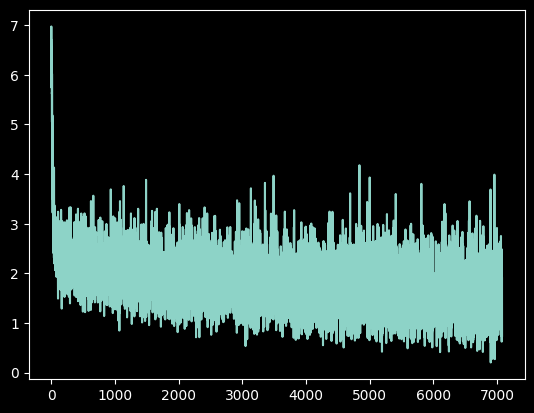

In [19]:
plt.plot(losses)

In [20]:
dataiter = iter(testloader)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum().item()
correct / total

0.5078